In [1]:
import pandas as pd
import glob
import pickle
from io import StringIO
import re
import textstat
from lexicalrichness import LexicalRichness
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy import stats

DATA_BASE_PATH = "./hein-daily/"
DATA_SAVE_PATH = "./preprocessed_data/"

PLOT_PATH = "./plots/"

IS_DEVELOPMENT = False


In [2]:
def write_to_disk(data, full_path):
    with open(full_path, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

def read_from_disk(full_path):
    with open(full_path, 'rb') as file:
        data = pickle.load(file)
        return data

In [498]:
# load raw data 
speeches_full_df = read_from_disk(DATA_SAVE_PATH + "raw_speeches.pickle")
descriptions_full_df = read_from_disk(DATA_SAVE_PATH + "raw_descriptions.pickle")
speakermaps_full_df = read_from_disk(DATA_SAVE_PATH + "raw_speakermaps.pickle")

In [ ]:
# for dev purposes, use only some parts of the data, every 400th row 
if IS_DEVELOPMENT:
    speeches_df = speeches_full_df.iloc[::400]
else:
    speeches_df = speeches_full_df


In [ ]:
### Info from raw-data
# state in SpeakerMaps: Speaker’s state from historical source. 
# state in Descriptions: Speaker’s state from speaker demarcation.
# gender in SpeakerMaps: Speaker’s gender from historical source: M(ale), F(emale).
# gender in Descriptions: Speaker’s gender from speaker demarcation: M(ale), F(emale), Special (titled speaker)
# chamber in SpeakerMaps & Descriptions: Chamber in which speech was made: H(ouse), S(enate), E(xtensions of Remarks), or N(one found)

### US Presidents since 1977 
# 1977 - 1981 Jimmy Carter D
# 1981 - 1989 Ronald Reagan R
# 1989 - 1993 George H. W. Bush R
# 1993 - 2001 Bill Clinton D
# 2001 - 2009 George W. Bush R
# 2009 - 2017 Barack Obama D
# 2017 - 2021 Donald Trump R
# 2021 -      Joe Biden D 

In [499]:
descriptions_full_df

,speech_id,chamber,date,number_within_file,speaker,first_name,last_name,state,gender,line_start,line_end,file,char_count,word_count,descriptions_filename
0,970000001,S,19810105,1,The VICE PRESIDENT,Unknown,Unknown,Unknown,Special,17,62,01051981.txt,1543,283,097
1,970000002,S,19810105,2,The VICE PRESIDENT,Unknown,Unknown,Unknown,Special,65,74,01051981.txt,334,55,097
2,970000003,S,19810105,3,The VICE,Unknown,Unknown,Unknown,Special,200,212,01051981.txt,466,82,097
3,970000004,S,19810105,4,The VICE PRESIDENT,Unknown,Unknown,Unknown,Special,858,864,01051981.txt,210,37,097
4,970000005,S,19810105,5,Mr. PERCY,Unknown,PERCY,Unknown,M,883,889,01051981.txt,201,34,097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866178,1140112286,E,20160909,220,Mr. YOUNG of Iowa,Unknown,YOUNG,Iowa,M,10620,10641,09092016.txt,756,126,114
3866179,1140112287,E,20160909,221,Mrs. WALORSKI,Unknown,WALORSKI,Unknown,F,10651,10694,09092016.txt,1760,300,114
3866180,1140112288,E,20160909,222,Mr. LANGEVIN,Unknown,LANGEVIN,Unknown,M,10701,10730,09092016.txt,495,84,114
3866181,1140112289,E,20160909,223,Mr. POE of Texas,Unknown,POE,Texas,M,10738,10771,09092016.txt,1206,208,114


In [500]:
speakermaps_full_df

,speakerid,speech_id,lastname,firstname,chamber,state,gender,party,district,nonvoting,speakermap_filename
0,97105301,970000005,PERCY,CHARLES,S,IL,M,R,NaN,voting,097
1,97105071,970000006,HUDDLESTON,WALTER,S,KY,M,D,NaN,voting,097
2,97106761,970000007,JACKSON,HENRY,S,WA,M,D,NaN,voting,097
3,97106981,970000008,STAFFORD,ROBERT,S,VT,M,R,NaN,voting,097
4,97104811,970000010,BAKER,HOWARD,S,TN,M,R,NaN,voting,097
...,...,...,...,...,...,...,...,...,...,...,...
2585802,114120860,1140111652,POLIS,JARED,H,CO,M,D,2.0,voting,114
2585803,114119880,1140112111,HURT,ROBERT,H,VA,M,R,5.0,voting,114
2585804,114118381,1140041159,REED,JOHN,S,RI,M,D,NaN,voting,114
2585805,114121330,1140082528,SESSIONS,PETE,H,TX,M,R,32.0,voting,114


In [501]:
# combine descriptions and speakermaps 
combined_df = pd.merge(descriptions_full_df, speakermaps_full_df, how = "outer", on = "speech_id")

In [502]:
combined_df.columns

Index(['speech_id', 'chamber_x', 'date', 'number_within_file', 'speaker',
       'first_name', 'last_name', 'state_x', 'gender_x', 'line_start',
       'line_end', 'file', 'char_count', 'word_count', 'descriptions_filename',
       'speakerid', 'lastname', 'firstname', 'chamber_y', 'state_y',
       'gender_y', 'party', 'district', 'nonvoting', 'speakermap_filename'],
      dtype='object')

In [503]:
# choose chamber column that contains more data 

def merge_chamber(data):
    if isinstance(data["chamber_x"], str):
        return data["chamber_x"]
    else:
        return data["chamber_y"]

combined_df["chamber"] = combined_df.apply(merge_chamber, axis = 1)

# drop chamber columns not used any longer 
combined_df = combined_df.drop(columns=["chamber_x","chamber_y"])

In [504]:
# choose gender column that contains more data 

def merge_gender(data):
    if isinstance(data["gender_x"], str):
        return data["gender_x"]
    else:
        return data["gender_y"]

combined_df["gender"] = combined_df.apply(merge_gender, axis = 1)

# drop gender columns not used any longer 
combined_df = combined_df.drop(columns=["gender_x","gender_y"])

In [505]:
# choose state column that contains more data 

def merge_state_old(data):
    if isinstance(data["state_x"], str):
        if data["state_x"].lower() == "unknown":
            if isinstance(data["state_y"], str):
                return data["state_y"]
            else:
                return data["state_x"]
        else:
            return data["state_x"]
    else:
        return data["state_y"]

def merge_state(data):
    if isinstance(data["state_y"], str):
        return data["state_y"]
    else:
        return data["state_x"]



combined_df["state"] = combined_df.apply(merge_state, axis = 1)

# drop gender columns not used any longer 
combined_df = combined_df.drop(columns=["state_x","state_y"])

In [506]:
combined_df[combined_df["state"].isin(['IL', 'KY', 'WA', 'VT', 'TN', 'CA', 'WV', 'ID', 'MD',
       'OR', 'LA', 'AR', 'TX', 'KS', 'HI', 'RI', 'NJ', 'VA', 'NC', 'DE',
       'AZ', 'SD', 'IN', 'CO', 'MN', 'MO', 'SC', 'NM', 'ND', 'MI', 'ME',
       'GA', 'PA', 'MA', 'MS', 'NY', 'OH', 'OK', 'WI'])]

,speech_id,date,number_within_file,speaker,first_name,last_name,line_start,line_end,file,char_count,...,speakerid,lastname,firstname,party,district,nonvoting,speakermap_filename,chamber,gender,state
4,970000005,19810105,5,Mr. PERCY,Unknown,PERCY,883,889,01051981.txt,201,...,97105301.0,PERCY,CHARLES,R,NaN,voting,097,S,M,IL
5,970000006,19810105,6,Mr. HUDDLESTON,Unknown,HUDDLESTON,895,901,01051981.txt,202,...,97105071.0,HUDDLESTON,WALTER,D,NaN,voting,097,S,M,KY
6,970000007,19810105,7,Mr. JAcKSON,Unknown,JACKSON,907,913,01051981.txt,201,...,97106761.0,JACKSON,HENRY,D,NaN,voting,097,S,M,WA
7,970000008,19810105,8,Mr. STAFFORD,Unknown,STAFFORD,932,938,01051981.txt,201,...,97106981.0,STAFFORD,ROBERT,R,NaN,voting,097,S,M,VT
9,970000010,19810105,10,Mr. BAKER,Unknown,BAKER,986,987,01051981.txt,49,...,97104811.0,BAKER,HOWARD,R,NaN,voting,097,S,M,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866136,1140112244,20160909,178,Mr. COFFMAN,Unknown,COFFMAN,7030,7050,09092016.txt,682,...,114118980.0,COFFMAN,MIKE,R,6.0,voting,114,H,M,CO
3866137,1140112245,20160909,179,Mr. DOLD,Unknown,DOLD,7074,7105,09092016.txt,1041,...,114122790.0,DOLD,BOB,R,10.0,voting,114,H,M,IL
3866138,1140112246,20160909,180,Mr. TED LIEU of California,TED,LIEU,7110,7141,09092016.txt,1058,...,114122890.0,LIEU,TED,D,33.0,voting,114,H,M,CA
3866139,1140112247,20160909,181,Mr. BUCSHON,Unknown,BUCSHON,7152,7179,09092016.txt,868,...,114118760.0,BUCSHON,LARRY,R,8.0,voting,114,H,M,IN


In [507]:
write_to_disk(combined_df, "./combined_df.pickle")
#combined_df = read_from_disk("./combined_df.pickle")

In [511]:
# merge speeches to descriptions, speakermaps
merged_df = pd.merge(combined_df, speeches_df, how = "right", on = "speech_id")

In [513]:
# Get rid of unused columns 
merged_df = merged_df.drop(columns=["line_start","line_end","file","descriptions_filename","speakermap_filename","speeches_filename"])

# drop district, mostly nans
merged_df = merged_df.drop(columns=["district"])



In [514]:
# drop nans in party
merged_df = merged_df.dropna(subset=["party"])

In [515]:
merged_df

,speech_id,date,number_within_file,speaker,first_name,last_name,char_count,word_count,speakerid,lastname,firstname,party,nonvoting,chamber,gender,state,speech
4,970000005,19810105,5,Mr. PERCY,Unknown,PERCY,201,34,97105301.0,PERCY,CHARLES,R,voting,S,M,IL,respectively. advanced to the desk of the Vive...
5,970000006,19810105,6,Mr. HUDDLESTON,Unknown,HUDDLESTON,202,34,97105071.0,HUDDLESTON,WALTER,D,voting,S,M,KY,respectively. advanced to the desk of the Vice...
6,970000007,19810105,7,Mr. JAcKSON,Unknown,JACKSON,201,34,97106761.0,JACKSON,HENRY,D,voting,S,M,WA,respectively. advanced to the desk of the Vice...
7,970000008,19810105,8,Mr. STAFFORD,Unknown,STAFFORD,201,34,97106981.0,STAFFORD,ROBERT,R,voting,S,M,VT,respectively. advanced to the desk of the Vice...
9,970000010,19810105,10,Mr. BAKER,Unknown,BAKER,49,9,97104811.0,BAKER,HOWARD,R,voting,S,M,TN,Mr. President. I suggest the absence of a quorum.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866136,1140112244,20160909,178,Mr. COFFMAN,Unknown,COFFMAN,682,109,114118980.0,COFFMAN,MIKE,R,voting,H,M,CO,Mr. Speaker. I rise today to congratulate the ...
3866137,1140112245,20160909,179,Mr. DOLD,Unknown,DOLD,1041,179,114122790.0,DOLD,BOB,R,voting,H,M,IL,Mr. Speaker. I rise today because this week is...
3866138,1140112246,20160909,180,Mr. TED LIEU of California,TED,LIEU,1058,189,114122890.0,LIEU,TED,D,voting,H,M,CA,Mr. Speaker. it has been 2 years since the peo...
3866139,1140112247,20160909,181,Mr. BUCSHON,Unknown,BUCSHON,868,125,114118760.0,BUCSHON,LARRY,R,voting,H,M,IN,Mr. Speaker. the University of Southern Indian...


In [516]:
merged_df[merged_df.isna().any(axis=1)]

,speech_id,date,number_within_file,speaker,first_name,last_name,char_count,word_count,speakerid,lastname,firstname,party,nonvoting,chamber,gender,state,speech


In [517]:
# compute character word count ratio 

merged_df["cwc_ratio"] = merged_df["char_count"] / merged_df["word_count"]

In [518]:
def apply_gunning_fog(data):
    '''
    Uses syllables.
    
    Select multi-sentence segment of 100 words. 
    Index = 0.4 * ((average sentence length) + 100 * (complex words / words))
    average sentence length = number of words (in multi-sentence segment) per number of sentences 
    complex words: consisting of three syllables or more, no proper nouns, no familiar jargon, no compound words; common suffixes (e.g. -ed) are not included as syllable
    
    Index value indicates education level necessary to comprehend text (6: Sixth grader, 17: College graduate)
    '''
    return textstat.gunning_fog(data["speech"])

def apply_coleman_liau(data):
    '''Character-based'''
    return textstat.coleman_liau_index(data["speech"])


def apply_dugast(data):
    '''
    The higher the value the more lexically rich. 
    (In contrast, for Maas index, the lower the more diverse.)
    '''
    
    lex = LexicalRichness(data["speech"])
    try: # exception occurs when word count and term counts are the same.
        dugast = lex.Dugast
    except Exception:
        dugast = np.nan 
        
    return dugast

# complexity/ readability
merged_df["gunning_fog"] = merged_df.apply(apply_gunning_fog, axis = 1) # syllable-based 
merged_df["coleman_liau"] = merged_df.apply(apply_coleman_liau, axis = 1)# character-based

# lexical richness 
merged_df["dugast"] = merged_df.apply(apply_dugast, axis = 1) 



In [519]:
merged_df

,speech_id,date,number_within_file,speaker,first_name,last_name,char_count,word_count,speakerid,lastname,...,party,nonvoting,chamber,gender,state,speech,cwc_ratio,gunning_fog,coleman_liau,dugast
4,970000005,19810105,5,Mr. PERCY,Unknown,PERCY,201,34,97105301.0,PERCY,...,R,voting,S,M,IL,respectively. advanced to the desk of the Vive...,5.911765,10.40,9.49,31.814506
5,970000006,19810105,6,Mr. HUDDLESTON,Unknown,HUDDLESTON,202,34,97105071.0,HUDDLESTON,...,D,voting,S,M,KY,respectively. advanced to the desk of the Vice...,5.941176,12.68,10.38,28.565822
6,970000007,19810105,7,Mr. JAcKSON,Unknown,JACKSON,201,34,97106761.0,JACKSON,...,D,voting,S,M,WA,respectively. advanced to the desk of the Vice...,5.911765,10.40,9.49,28.565822
7,970000008,19810105,8,Mr. STAFFORD,Unknown,STAFFORD,201,34,97106981.0,STAFFORD,...,R,voting,S,M,VT,respectively. advanced to the desk of the Vice...,5.911765,10.40,9.49,28.565822
9,970000010,19810105,10,Mr. BAKER,Unknown,BAKER,49,9,97104811.0,BAKER,...,R,voting,S,M,TN,Mr. President. I suggest the absence of a quorum.,5.444444,8.04,5.42,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866136,1140112244,20160909,178,Mr. COFFMAN,Unknown,COFFMAN,682,109,114118980.0,COFFMAN,...,R,voting,H,M,CO,Mr. Speaker. I rise today to congratulate the ...,6.256881,9.10,10.99,57.105327
3866137,1140112245,20160909,179,Mr. DOLD,Unknown,DOLD,1041,179,114122790.0,DOLD,...,R,voting,H,M,IL,Mr. Speaker. I rise today because this week is...,5.815642,8.20,9.45,61.464561
3866138,1140112246,20160909,180,Mr. TED LIEU of California,TED,LIEU,1058,189,114122890.0,LIEU,...,D,voting,H,M,CA,Mr. Speaker. it has been 2 years since the peo...,5.597884,7.37,7.28,54.796715
3866139,1140112247,20160909,181,Mr. BUCSHON,Unknown,BUCSHON,868,125,114118760.0,BUCSHON,...,R,voting,H,M,IN,Mr. Speaker. the University of Southern Indian...,6.944000,11.28,15.41,64.327406


In [520]:
merged_df.columns

Index(['speech_id', 'date', 'number_within_file', 'speaker', 'first_name',
       'last_name', 'char_count', 'word_count', 'speakerid', 'lastname',
       'firstname', 'party', 'nonvoting', 'chamber', 'gender', 'state',
       'speech', 'cwc_ratio', 'gunning_fog', 'coleman_liau', 'dugast'],
      dtype='object')

In [521]:
merged_df["date_year"] = merged_df["date"] // 10000

In [3]:
#write_to_disk(merged_df, "./merged_df.pickle")
#merged_df = read_from_disk("./merged_df.pickle")
merged_df = read_from_disk("/Users/stefan/Desktop/congress/merged_df.pickle")

In [4]:
merged_df

,speech_id,date,number_within_file,speaker,first_name,last_name,char_count,word_count,speakerid,lastname,...,nonvoting,chamber,gender,state,speech,cwc_ratio,gunning_fog,coleman_liau,dugast,date_year
4,970000005,19810105,5,Mr. PERCY,Unknown,PERCY,201,34,97105301.0,PERCY,...,voting,S,M,IL,respectively. advanced to the desk of the Vive...,5.911765,10.40,9.49,31.814506,1981
5,970000006,19810105,6,Mr. HUDDLESTON,Unknown,HUDDLESTON,202,34,97105071.0,HUDDLESTON,...,voting,S,M,KY,respectively. advanced to the desk of the Vice...,5.941176,12.68,10.38,28.565822,1981
6,970000007,19810105,7,Mr. JAcKSON,Unknown,JACKSON,201,34,97106761.0,JACKSON,...,voting,S,M,WA,respectively. advanced to the desk of the Vice...,5.911765,10.40,9.49,28.565822,1981
7,970000008,19810105,8,Mr. STAFFORD,Unknown,STAFFORD,201,34,97106981.0,STAFFORD,...,voting,S,M,VT,respectively. advanced to the desk of the Vice...,5.911765,10.40,9.49,28.565822,1981
9,970000010,19810105,10,Mr. BAKER,Unknown,BAKER,49,9,97104811.0,BAKER,...,voting,S,M,TN,Mr. President. I suggest the absence of a quorum.,5.444444,8.04,5.42,NaN,1981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866136,1140112244,20160909,178,Mr. COFFMAN,Unknown,COFFMAN,682,109,114118980.0,COFFMAN,...,voting,H,M,CO,Mr. Speaker. I rise today to congratulate the ...,6.256881,9.10,10.99,57.105327,2016
3866137,1140112245,20160909,179,Mr. DOLD,Unknown,DOLD,1041,179,114122790.0,DOLD,...,voting,H,M,IL,Mr. Speaker. I rise today because this week is...,5.815642,8.20,9.45,61.464561,2016
3866138,1140112246,20160909,180,Mr. TED LIEU of California,TED,LIEU,1058,189,114122890.0,LIEU,...,voting,H,M,CA,Mr. Speaker. it has been 2 years since the peo...,5.597884,7.37,7.28,54.796715,2016
3866139,1140112247,20160909,181,Mr. BUCSHON,Unknown,BUCSHON,868,125,114118760.0,BUCSHON,...,voting,H,M,IN,Mr. Speaker. the University of Southern Indian...,6.944000,11.28,15.41,64.327406,2016


# Plotting
Using 95% confidence intervals. 

### Speech complexity: House vs Senate

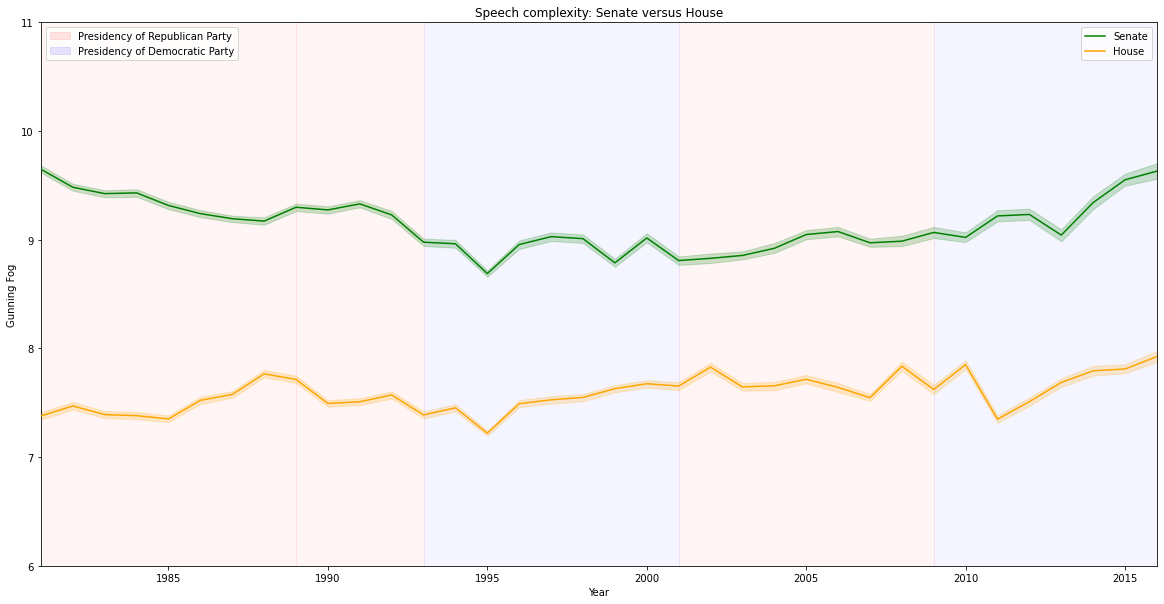

In [9]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = merged_df[merged_df["chamber"].isin(["H","S"])], x="date_year", y="gunning_fog", hue ="chamber", palette = {"S":"green","H":"orange"}, zorder = 10, ax = ax)


# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 7, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 7, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 7, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 7, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 7, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(1981, 2016))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[0].set_text("Senate")
legend.get_texts()[1].set_text("House")

# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)

# Title
plt.title("Speech complexity: Senate versus House") 
plt.savefig(PLOT_PATH + 'complexity_sen_vs_house.png')
plt.show()


In [10]:
by_chamber_means = merged_df[merged_df["chamber"].isin(["H","S"])].groupby("chamber").mean()["gunning_fog"].reset_index()
by_chamber_means = by_chamber_means.append(by_chamber_means)
by_chamber_means["year"] = [1981,1981,2016,2016]


/var/folders/zd/swdt0bn14k10m4mgky1pzh8m0000gn/T/ipykernel_34056/4246224309.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  by_chamber_means = by_chamber_means.append(by_chamber_means)


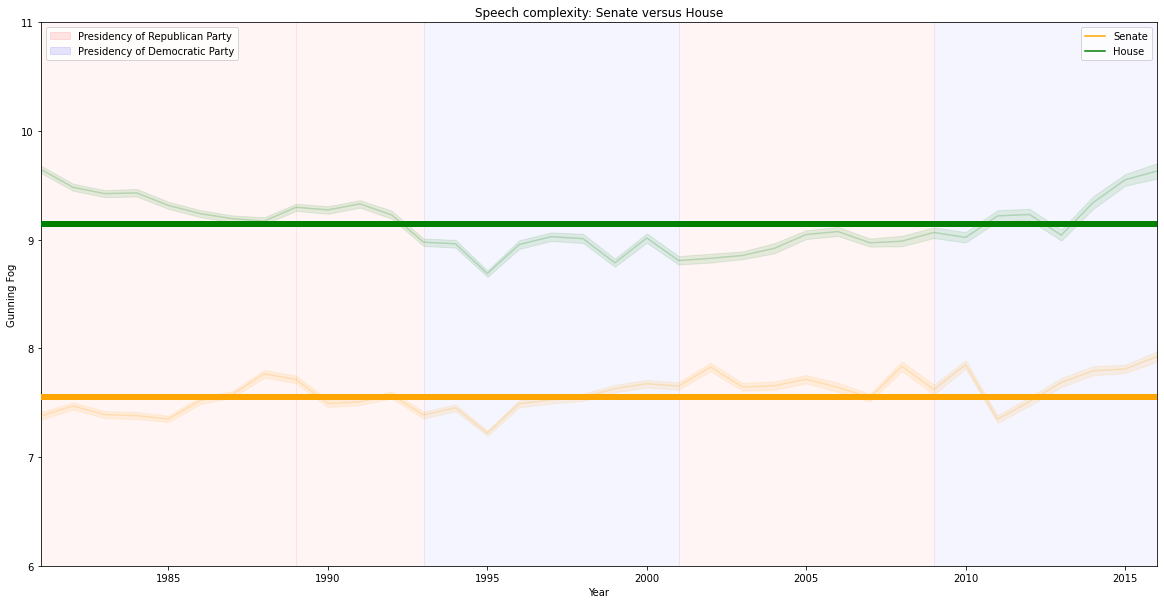

In [11]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = merged_df[merged_df["chamber"].isin(["H","S"])], x="date_year", y="gunning_fog", hue ="chamber", palette = {"S":"green","H":"orange"}, zorder = 10, legend = False, alpha = 0.2, err_kws={"alpha": .1}, ax = ax)
sns.lineplot(data = by_chamber_means.reset_index(drop=True), x = "year", y= "gunning_fog", hue = "chamber", palette = {"S":"green","H":"orange"}, linewidth = 6, zorder = 12, ax = ax)


# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 7, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 7, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 7, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 7, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 7, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(1981, 2016))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[0].set_text("Senate")
legend.get_texts()[1].set_text("House")

# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)

# Title
plt.title("Speech complexity: Senate versus House") 
plt.savefig(PLOT_PATH + 'complexity_sen_vs_house_with_means.png')
plt.show()



In [12]:
house_vals = merged_df[merged_df["chamber"] == "H"]["gunning_fog"].values
senate_vals = merged_df[merged_df["chamber"] == "S"]["gunning_fog"].values

print("Variance House sample:", np.var(house_vals), "\nVariance Senate sample:", np.var(senate_vals) )

print("\nT-Test for difference of 'Gunning Fog' means, full time-frame, House vs Senate")
print("Assuming different variance")
t_test = stats.ttest_ind(house_vals,senate_vals,equal_var = False)
alpha=0.05
print("p-value:", t_test[1])
if(t_test[1] < alpha):
    print("Sample means are significantly different!")
else:
    print("Sample means are not significantly different!")

Variance House sample: 11.603824357978752 
Variance Senate sample: 13.752426137495188

T-Test for difference of 'Gunning Fog' means, full time-frame, House vs Senate
Assuming different variance
p-value: 0.0
Sample means are significantly different!


### Speech complexity Party: House & Senate

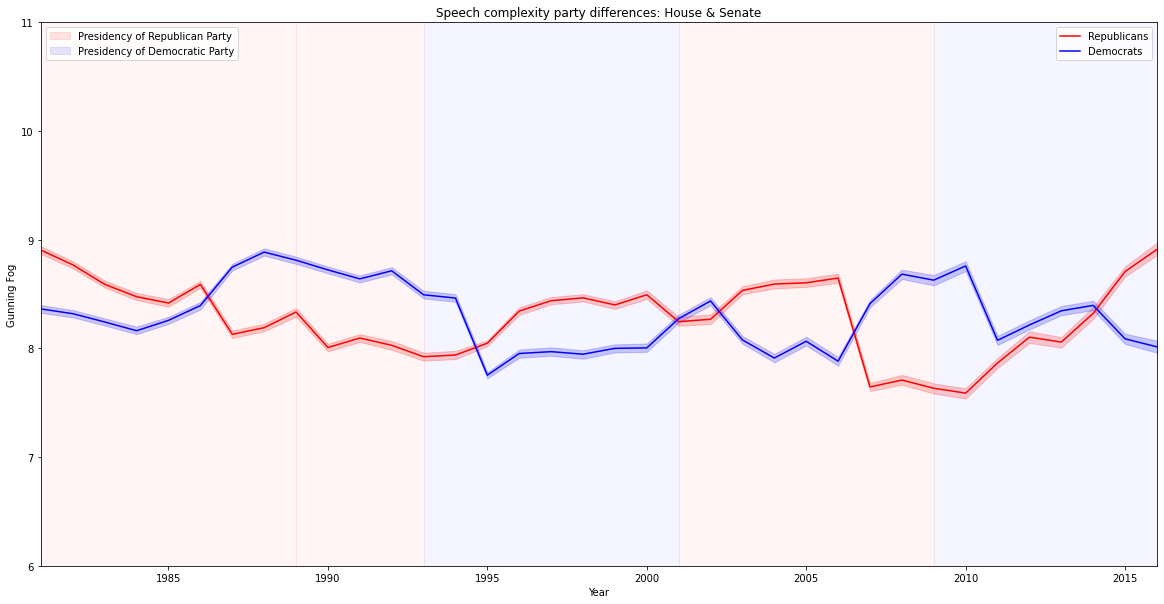

In [537]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = merged_df[merged_df["party"].isin(["R","D"])], x="date_year", y="gunning_fog", hue ="party", palette = {"R":"red","D":"blue"}, zorder = 10, ax = ax)

# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 5, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(1981, 2016))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[0].set_text("Republicans")
legend.get_texts()[1].set_text("Democrats")


# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)


plt.title("Speech complexity party differences: House & Senate")
plt.savefig(PLOT_PATH + 'complexity_party_house_and_senate.png')
plt.show()

### Overall mean 

In [561]:
by_party_means = merged_df[merged_df["party"].isin(["R","D"])].groupby("party").mean()["gunning_fog"].reset_index()
by_party_means = by_party_means.append(by_party_means)
by_party_means["year"] = [1981,1981,2016,2016]

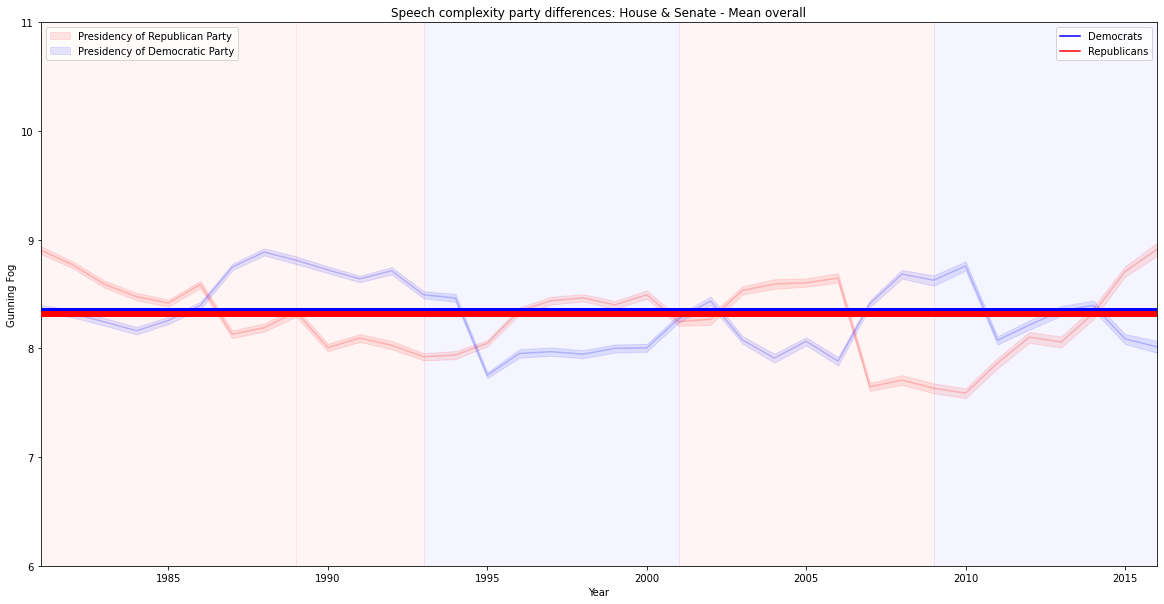

In [569]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = merged_df[merged_df["party"].isin(["R","D"])], x="date_year", y="gunning_fog", hue ="party", palette = {"R":"red","D":"blue"}, zorder = 10, legend = False, alpha = 0.2, err_kws={"alpha": .1}, ax = ax)
sns.lineplot(data = by_party_means.reset_index(drop=True), x = "year", y= "gunning_fog", hue = "party", palette = {"R":"red","D":"blue"}, linewidth = 6, zorder = 12, ax = ax)

# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 5, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(1981, 2016))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[0].set_text("Democrats")
legend.get_texts()[1].set_text("Republicans")


# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)


plt.title("Speech complexity party differences: House & Senate - Mean overall")
plt.savefig(PLOT_PATH + 'complexity_party_house_and_senate_with_means.png')
plt.show()

In [542]:
rep_vals_sen_house = merged_df[merged_df["party"].isin(["R"])]["gunning_fog"].values
dem_vals_sen_house = merged_df[merged_df["party"].isin(["D"])]["gunning_fog"].values

In [543]:
print("Variance Republicans sample:", np.var(dem_vals_sen_house), "\nVariance Democrats sample:", np.var(rep_vals_sen_house) )

print("\nT-Test for difference of 'Gunning Fog' means, full time-frame, House & Senate combined, Republicans versus Democrats")
print("Assuming equal variance")
t_test = stats.ttest_ind(rep_vals_sen_house,dem_vals_sen_house)
alpha=0.05
print("p-value:", t_test[1])
if(t_test[1] < alpha):
    print("Sample means are significantly different!")
else:
    print("Sample means are not significantly different!")

Variance Republicans sample: 13.13322682514526 
Variance Democrats sample: 13.466243162001419

T-Test for difference of 'Gunning Fog' means, full time-frame, House & Senate combined, Republicans versus Democrats
Assuming equal variance
p-value: 4.876733515458098e-09
Sample means are significantly different!


### Mean per Presidency

In [538]:
# Create interval based means
presidency_mean_df = merged_df[merged_df["party"].isin(["R","D"])]
presidency_mean_df = presidency_mean_df.groupby([pd.cut(presidency_mean_df["date_year"], [1981,1989,1993,2001,2009,2016]), "party"]).mean()["gunning_fog"].reset_index()

In [539]:
# Extend intervals to one value per row
presidency_mean_extended_df = pd.DataFrame(columns=('date_year', 'party', 'gunning_fog'))

idx = 0
for _, row in presidency_mean_df.iterrows():
    for year in range(row["date_year"].left, row["date_year"].right + 1):
        presidency_mean_extended_df.loc[idx] = [year, row["party"], row["gunning_fog"]] 
        idx += 1

In [540]:
# Add little offset to second occuring year - party combination for nicer plotting
presidency_mean_temp_df = presidency_mean_extended_df.copy(deep = True)
presidency_mean_temp_df["modified_date_year"] = presidency_mean_temp_df["date_year"]
presidency_mean_temp_df = presidency_mean_temp_df.groupby(["date_year","party"]).apply(lambda n: n["modified_date_year"] + (np.arange(len(n["modified_date_year"]))) * 0.01)
presidency_mean_temp_df = presidency_mean_temp_df.reset_index().set_index("level_2").sort_index().reset_index(drop = True)

# Update year 
presidency_mean_extended_df["modified_date_year"] = presidency_mean_temp_df["modified_date_year"]


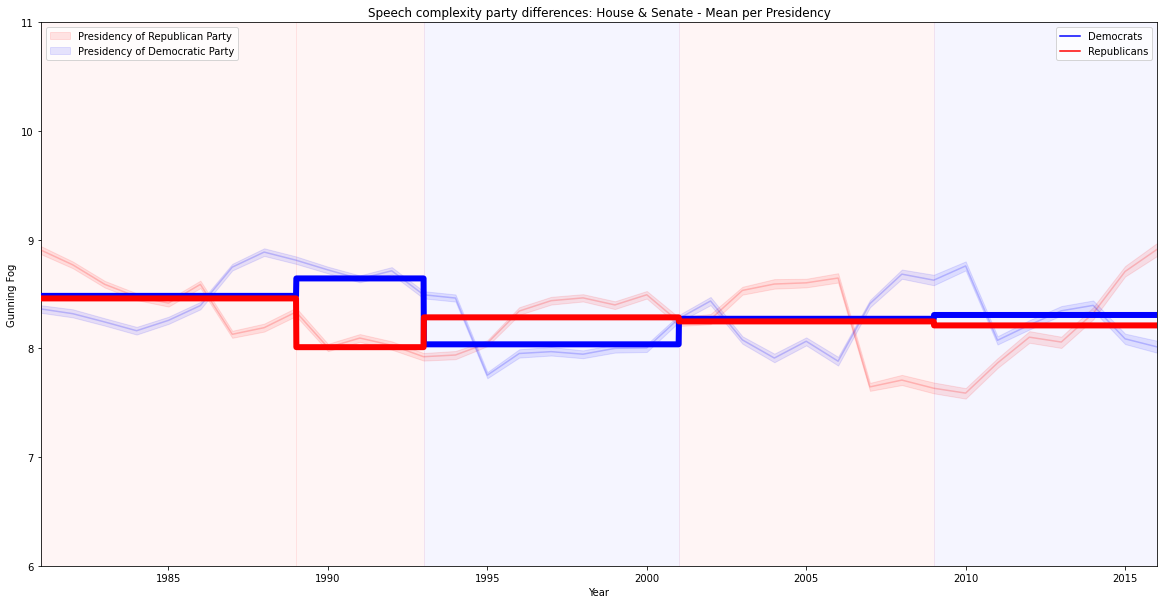

In [570]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = merged_df[merged_df["party"].isin(["R","D"])], x="date_year", y="gunning_fog", hue ="party", palette = {"R":"red","D":"blue"}, zorder = 10, legend = False, alpha = 0.2, err_kws={"alpha": .1}, ax = ax)
sns.lineplot(data = presidency_mean_extended_df, x="modified_date_year", y="gunning_fog", hue ="party", palette = {"R":"red","D":"blue"}, linewidth = 6, zorder = 12, ax = ax)


# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 5, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(1981, 2016))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[0].set_text("Democrats")
legend.get_texts()[1].set_text("Republicans")


# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)


plt.title("Speech complexity party differences: House & Senate - Mean per Presidency")
plt.savefig(PLOT_PATH + 'complexity_party_house_and_senate_with_presidency_means.png')
plt.show()

###  Speech complexity Party: House only 

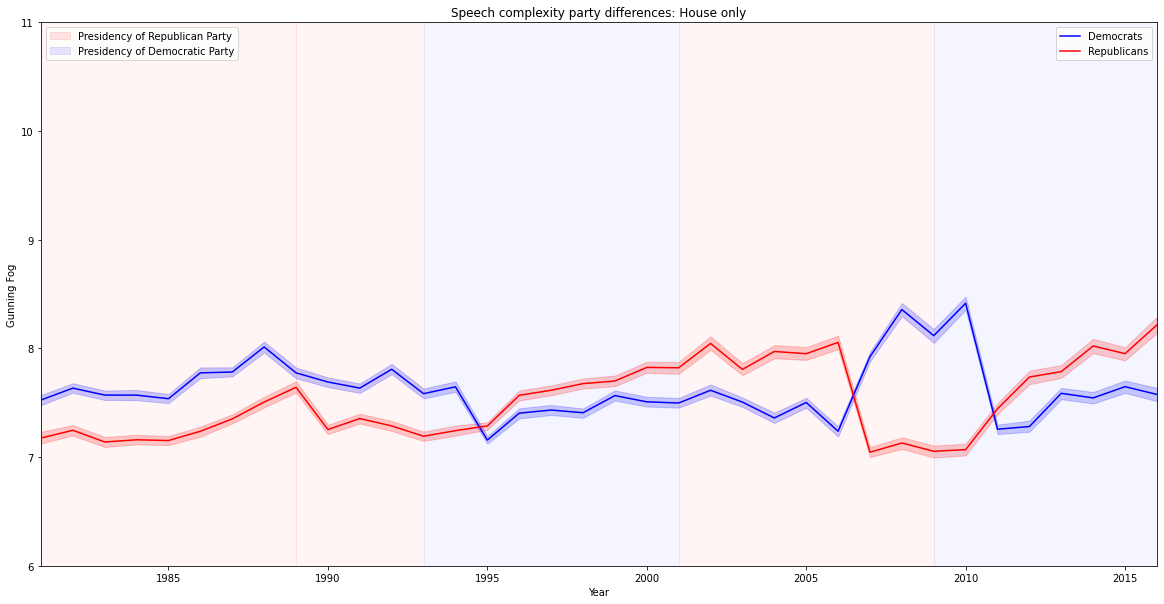

In [24]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = merged_df[(merged_df["party"].isin(["R","D"])) & (merged_df["chamber"] == "H")], x="date_year", y="gunning_fog", hue ="party", palette = {"R":"red","D":"blue"}, zorder = 10, ax = ax)

# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 5, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(1981, 2016))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[1].set_text("Republicans")
legend.get_texts()[0].set_text("Democrats")


# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)

plt.title("Speech complexity party differences: House only")
plt.savefig(PLOT_PATH + 'complexity_party_house_only.png')
plt.show()


In [22]:
by_party_house_means = merged_df[(merged_df["party"].isin(["R","D"])) & (merged_df["chamber"] == "H")].groupby("party").mean()["gunning_fog"].reset_index()
by_party_house_means = by_party_house_means.append(by_party_house_means)
by_party_house_means["year"] = [1981,1981,2016,2016]

/var/folders/zd/swdt0bn14k10m4mgky1pzh8m0000gn/T/ipykernel_30003/2452094943.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  by_party_house_means = by_party_house_means.append(by_party_house_means)


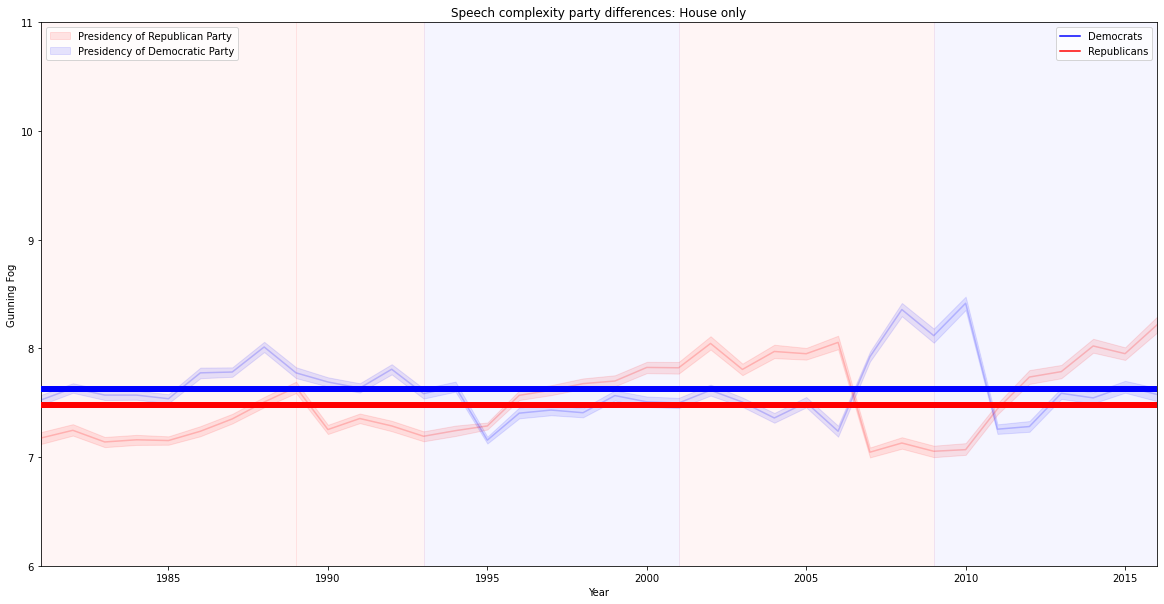

In [25]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = merged_df[(merged_df["party"].isin(["R","D"])) & (merged_df["chamber"] == "H")], x="date_year", y="gunning_fog", hue ="party", palette = {"R":"red","D":"blue"}, zorder = 10, legend = False, alpha = 0.2, err_kws={"alpha": .1}, ax = ax)
sns.lineplot(data = by_party_house_means.reset_index(drop=True), x = "year", y = "gunning_fog", hue = "party", palette = {"R":"red","D":"blue"}, linewidth = 6, zorder = 12, ax = ax)


# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 5, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(1981, 2016))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[1].set_text("Republicans")
legend.get_texts()[0].set_text("Democrats")


# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)

plt.title("Speech complexity party differences: House only")
plt.savefig(PLOT_PATH + 'complexity_party_house_only_with_means.png')
plt.show()



In [545]:
rep_vals_house_only = merged_df[(merged_df["party"].isin(["R"])) & (merged_df["chamber"] == "H")]["gunning_fog"].values
dem_vals_house_only = merged_df[(merged_df["party"].isin(["D"])) & (merged_df["chamber"] == "H")]["gunning_fog"].values

print("Variance Republicans sample:", np.var(dem_vals_house_only), "\nVariance Democrats sample:", np.var(rep_vals_house_only) )

print("\nT-Test for difference of 'Gunning Fog' means, full time-frame, House only, Republicans versus Democrats")
print("Assuming different variance")
t_test = stats.ttest_ind(rep_vals_house_only,dem_vals_house_only,equal_var = False)
alpha=0.05
print("p-value:", t_test[1])
if(t_test[1] < alpha):
    print("Sample means are significantly different!")
else:
    print("Sample means are not significantly different!")

Variance Republicans sample: 11.518441270693474 
Variance Democrats sample: 11.690484251609876

T-Test for difference of 'Gunning Fog' means, full time-frame, House only, Republicans versus Democrats
Assuming different variance
p-value: 6.593831332139039e-139
Sample means are significantly different!


###  Speech complexity Party: Senate

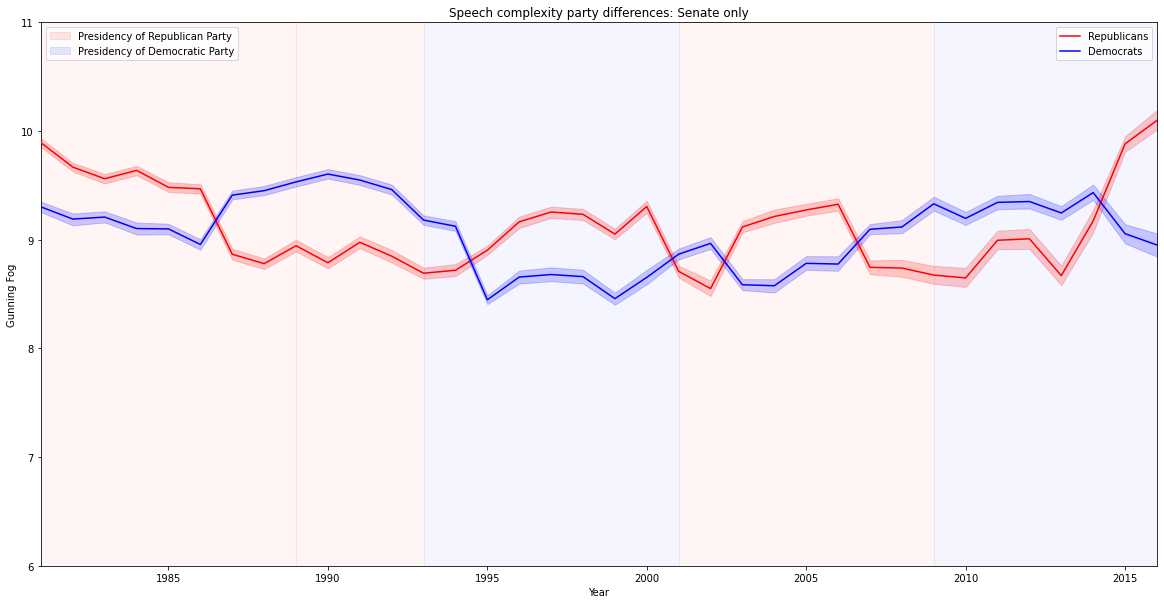

In [19]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = merged_df[(merged_df["party"].isin(["R","D"])) & (merged_df["chamber"] == "S")], x="date_year", y="gunning_fog", hue ="party", palette = {"R":"red","D":"blue"}, zorder = 10, ax = ax)


# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 5, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(1981, 2016))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[0].set_text("Republicans")
legend.get_texts()[1].set_text("Democrats")


# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)

plt.title("Speech complexity party differences: Senate only")
plt.savefig(PLOT_PATH + 'complexity_party_senate_only.png')
plt.show()

In [17]:
by_party_senate_means = merged_df[(merged_df["party"].isin(["R","D"])) & (merged_df["chamber"] == "S")].groupby("party").mean()["gunning_fog"].reset_index()
by_party_senate_means = by_party_senate_means.append(by_party_senate_means)
by_party_senate_means["year"] = [1981,1981,2016,2016]


/var/folders/zd/swdt0bn14k10m4mgky1pzh8m0000gn/T/ipykernel_30003/953088022.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  by_party_senate_means = by_party_senate_means.append(by_party_senate_means)


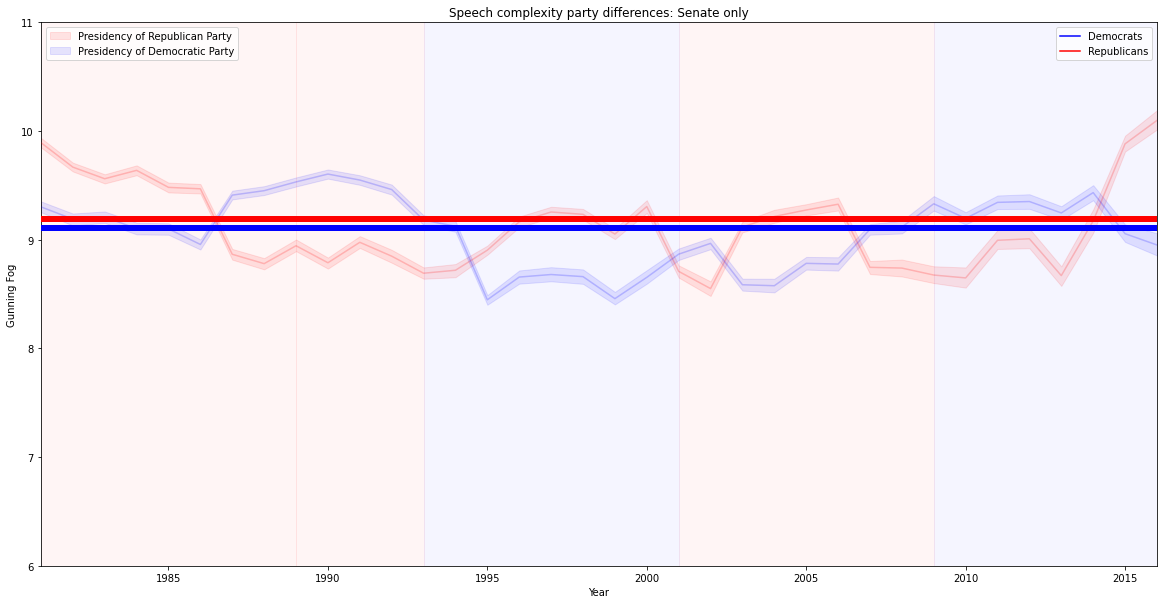

In [26]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = merged_df[(merged_df["party"].isin(["R","D"])) & (merged_df["chamber"] == "S")], x="date_year", y="gunning_fog", hue ="party", palette = {"R":"red","D":"blue"}, zorder = 10, legend = False, alpha = 0.2, err_kws={"alpha": .1}, ax = ax)
sns.lineplot(data = by_party_senate_means.reset_index(drop=True), x = "year", y = "gunning_fog", hue = "party", palette = {"R":"red","D":"blue"}, linewidth = 6, zorder = 12, ax = ax)



# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 5, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(1981, 2016))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[1].set_text("Republicans")
legend.get_texts()[0].set_text("Democrats")


# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)

plt.title("Speech complexity party differences: Senate only")
plt.savefig(PLOT_PATH + 'complexity_party_senate_only_with_means.png')
plt.show()

In [548]:
rep_vals_sen_only = merged_df[(merged_df["party"].isin(["R"])) & (merged_df["chamber"] == "S")]["gunning_fog"].values
dem_vals_sen_only = merged_df[(merged_df["party"].isin(["D"])) & (merged_df["chamber"] == "S")]["gunning_fog"].values

print("Variance Republicans sample:", np.var(dem_vals_sen_only), "\nVariance Democrats sample:", np.var(rep_vals_sen_only) )

print("\nT-Test for difference of 'Gunning Fog' means, full time-frame, Senate only, Republicans versus Democrats")
print("Assuming equal variance")
t_test = stats.ttest_ind(rep_vals_sen_only,dem_vals_sen_only,equal_var = True)
alpha=0.05
print("p-value:", t_test[1])
if(t_test[1] < alpha):
    print("Sample means are significantly different!")
else:
    print("Sample means are not significantly different!")

Variance Republicans sample: 13.71262864382657 
Variance Democrats sample: 13.80758703957412

T-Test for difference of 'Gunning Fog' means, full time-frame, Senate only, Republicans versus Democrats
Assuming equal variance
p-value: 2.1584693483592485e-34
Sample means are significantly different!


### Unused

In [ ]:
# Fit polynomial 
if False:
    x = merged_df[merged_df["chamber"].isin(["H"])]["date_year"].unique()
    x.sort()
    y_H = merged_df[merged_df["chamber"].isin(["H"])].groupby("date_year").mean()["gunning_fog"].to_numpy()
    polys = np.polyfit(x, y_H, 5)
    res = 0
    for idx, elem in enumerate(polys):
        print(len(polys) - idx - 1)
        res += x ** (len(polys) - idx - 1) * polys[idx]


In [ ]:
# speech complexity state
if False:
    fig, ax = plt.subplots(figsize=(20,10))
    sns.barplot(data = merged_df, x ="state", y="gunning_fog" , zorder = 10, ax = ax)

In [ ]:
# DUGAST 
# house & senate 

if False: 
    fig, ax = plt.subplots(figsize=(20,10))

    sns.lineplot(data = merged_df[merged_df["party"].isin(["R","D"])], x="date_year",y="dugast", hue = 'party', palette = {"R":"red","D":"blue"}, zorder = 10, ax = ax)


    # Add presidencies
    rect_1 = patches.Rectangle((1981, 40), 8, 70, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
    rect_2 = patches.Rectangle((1989, 40), 4, 70, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
    rect_3 = patches.Rectangle((1993, 40), 8, 70, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
    rect_4 = patches.Rectangle((2001, 40), 8, 70, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
    rect_5 = patches.Rectangle((2009, 40), 8, 70, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
    ax.add_patch(rect_1)
    ax.add_patch(rect_2)
    ax.add_patch(rect_3)
    ax.add_patch(rect_4)
    ax.add_patch(rect_5)

    # Clean up look 
    ax.set(xlim=(1981, 2016))
    ax.set(ylim=(40, 110))
    ax.set_ylabel("Dugast")
    ax.set_xlabel("Year")
    legend=ax.legend()
    legend.get_texts()[0].set_text("Republicans")
    legend.get_texts()[1].set_text("Democrats")

    plt.title("House & Senate")

In [ ]:
# DUGAST 
# house only 

if False:
    fig, ax = plt.subplots(figsize=(20,10))

    sns.lineplot(data = merged_df[(merged_df["party"].isin(["R","D"])) & (merged_df["chamber"] == "H")], x="date_year",y="dugast", hue = 'party', palette = {"R":"red","D":"blue"}, zorder = 10, ax = ax)


    # Create a Rectangle patch
    rect_1 = patches.Rectangle((1981, 40), 8, 70, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
    rect_2 = patches.Rectangle((1989, 40), 4, 70, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
    rect_3 = patches.Rectangle((1993, 40), 8, 70, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
    rect_4 = patches.Rectangle((2001, 40), 8, 70, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
    rect_5 = patches.Rectangle((2009, 40), 8, 70, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)


    ax.add_patch(rect_1)
    ax.add_patch(rect_2)
    ax.add_patch(rect_3)
    ax.add_patch(rect_4)
    ax.add_patch(rect_5)

    plt.title("House")

In [ ]:
# DUGAST 
# senate only 

if False:
    fig, ax = plt.subplots(figsize=(20,10))

    sns.lineplot(data = merged_df[(merged_df["party"].isin(["R","D"])) & (merged_df["chamber"] == "S")], x="date_year",y="dugast", hue = 'party', palette = {"R":"red","D":"blue"}, zorder = 10, ax = ax)


    # Create a Rectangle patch
    rect_1 = patches.Rectangle((1981, 40), 8, 70, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
    rect_2 = patches.Rectangle((1989, 40), 4, 70, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
    rect_3 = patches.Rectangle((1993, 40), 8, 70, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
    rect_4 = patches.Rectangle((2001, 40), 8, 70, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
    rect_5 = patches.Rectangle((2009, 40), 8, 70, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)


    ax.add_patch(rect_1)
    ax.add_patch(rect_2)
    ax.add_patch(rect_3)
    ax.add_patch(rect_4)
    ax.add_patch(rect_5)

    plt.title("Senate")

# Classifier

In [5]:
classifier_data = merged_df.copy(deep=True).reset_index(drop=True)
classifier_data = classifier_data.drop(columns=["speech","speech_id","date","number_within_file","speaker","first_name","last_name","speakerid","lastname","firstname"])

# drop non_voting
classifier_data = classifier_data.drop(columns=["nonvoting"])


In [6]:
# keep only Republicans and Democrats data
classifier_data = classifier_data[classifier_data["party"].isin(["R","D"])]

In [7]:
# map data to purely numerical

party_map = {0:'R', 1:'D'}
voting_map = {0:'nonvoting', 1:'voting'}
chamber_map = {0:'S',1:'H',2:'None'}
gender_map = {0:'M',1:'F',2:'Unknown'}
state_map = {0:'SC', 1:'CA', 2:'TN', 3:'KS', 4:'AZ', 5:'NC', 6:'WV', 7:'NJ', 8:'NY', 9:'MD', 10:'PA',
       11:'RI', 12:'OH', 13:'VA', 14:'IL', 15:'OK', 16:'AR', 17:'TX', 18:'MI', 19:'WA', 20:'NE', 21:'UT',
       22:'GA', 23:'AK', 24:'MO', 25:'CO', 26:'IN', 27:'WI', 28:'MA', 29:'MT', 30:'AL', 31:'VT', 32:'NM',
       33:'PR', 34:'MN', 35:'MS', 36:'CT', 37:'OR', 38:'FL', 39:'ID', 40:'NV', 41:'IA', 42:'ME', 43:'DC',
       44:'SD', 45:'KY', 46:'LA', 47:'ND', 48:'NH', 49:'WY', 50:'DE', 51:'HI', 52:'AS', 53:'GU', 54:'VI',
       55:'MP'}


classifier_data = classifier_data.replace({"party":{v: k for k, v in party_map.items()}, "nonvoting":{v: k for k, v in voting_map.items()}, \
                        "chamber":{v: k for k, v in chamber_map.items()}, "gender":{v: k for k, v in gender_map.items()}, \
                        "state":{v: k for k, v in state_map.items()}})


In [9]:
classifier_data = classifier_data.dropna()

In [11]:
classifier_data

,char_count,word_count,party,chamber,gender,state,cwc_ratio,gunning_fog,coleman_liau,dugast,date_year
0,201,34,0,0,0,14,5.911765,10.40,9.49,31.814506,1981
1,202,34,1,0,0,45,5.941176,12.68,10.38,28.565822,1981
2,201,34,1,0,0,19,5.911765,10.40,9.49,28.565822,1981
3,201,34,0,0,0,31,5.911765,10.40,9.49,28.565822,1981
5,111,17,0,0,0,2,6.529412,10.46,11.33,41.343545,1981
...,...,...,...,...,...,...,...,...,...,...,...
2585801,1744,295,0,1,0,1,5.911864,7.60,8.67,56.187454,2016
2585802,682,109,0,1,0,25,6.256881,9.10,10.99,57.105327,2016
2585803,1041,179,0,1,0,14,5.815642,8.20,9.45,61.464561,2016
2585804,1058,189,1,1,0,1,5.597884,7.37,7.28,54.796715,2016


In [46]:
# train test split
train_data, test_data = train_test_split(classifier_data,train_size = 0.8, shuffle = True)

In [47]:
train_target = train_data["party"]
train_data = train_data.drop(columns = "party")

test_target = test_data["party"]
test_data = test_data.drop(columns = "party")

In [14]:
# train on all data 
rf = RandomForestClassifier(verbose = 1,n_jobs = 8)
rf.fit(train_data, train_target)
rf.score(test_data, test_target)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished


0.8198097398880609

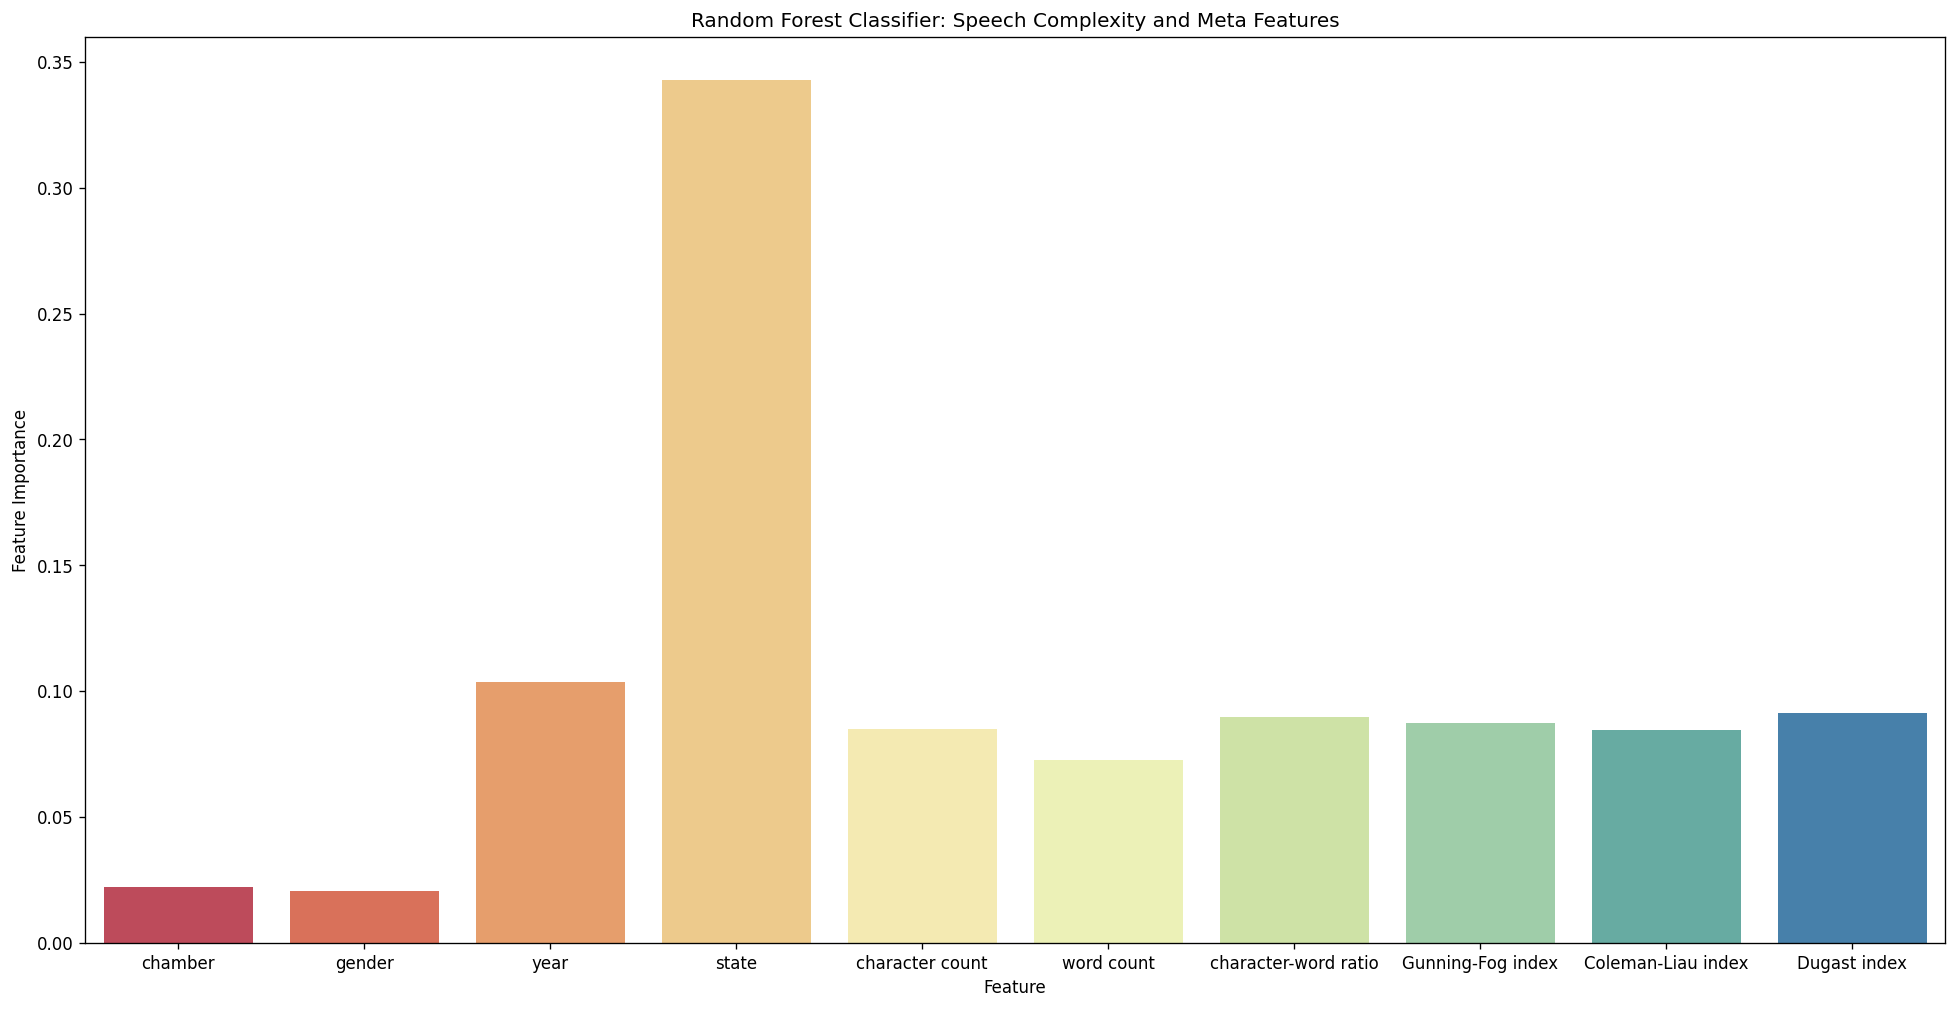

In [48]:
fig, ax = plt.subplots(1,1, figsize = (20,10), dpi = 120)

remapped_order =  ['chamber', 'gender', 'date_year', 'state', 'char_count', 'word_count', 'cwc_ratio', 'gunning_fog', 'coleman_liau', 'dugast']
remapped_labels = ["chamber","gender", "year", "state", "character count","word count", "character-word ratio","Gunning-Fog index","Coleman-Liau index","Dugast index"]

sns.barplot(x=train_data.columns, y = rf.feature_importances_, palette = "Spectral", order = remapped_order, ax = ax)
ax.set_ylabel("Feature Importance")
ax.set_xlabel("Feature")
ax.axes.set_xticklabels(remapped_labels)

plt.title("Random Forest Classifier: Speech Complexity and Meta Features")
plt.savefig(PLOT_PATH + 'random_forest_many.png')
plt.show()


In [42]:
# drop some 
train_data = train_data.drop(columns = ["chamber","gender","date_year","state"])
test_data = test_data.drop(columns = ["chamber","gender","date_year","state"])


rf_2 = RandomForestClassifier(verbose = 1,n_jobs = 8)
rf_2.fit(train_data, train_target)
rf_2.score(test_data, test_target)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.0s finished


0.5250930451200846

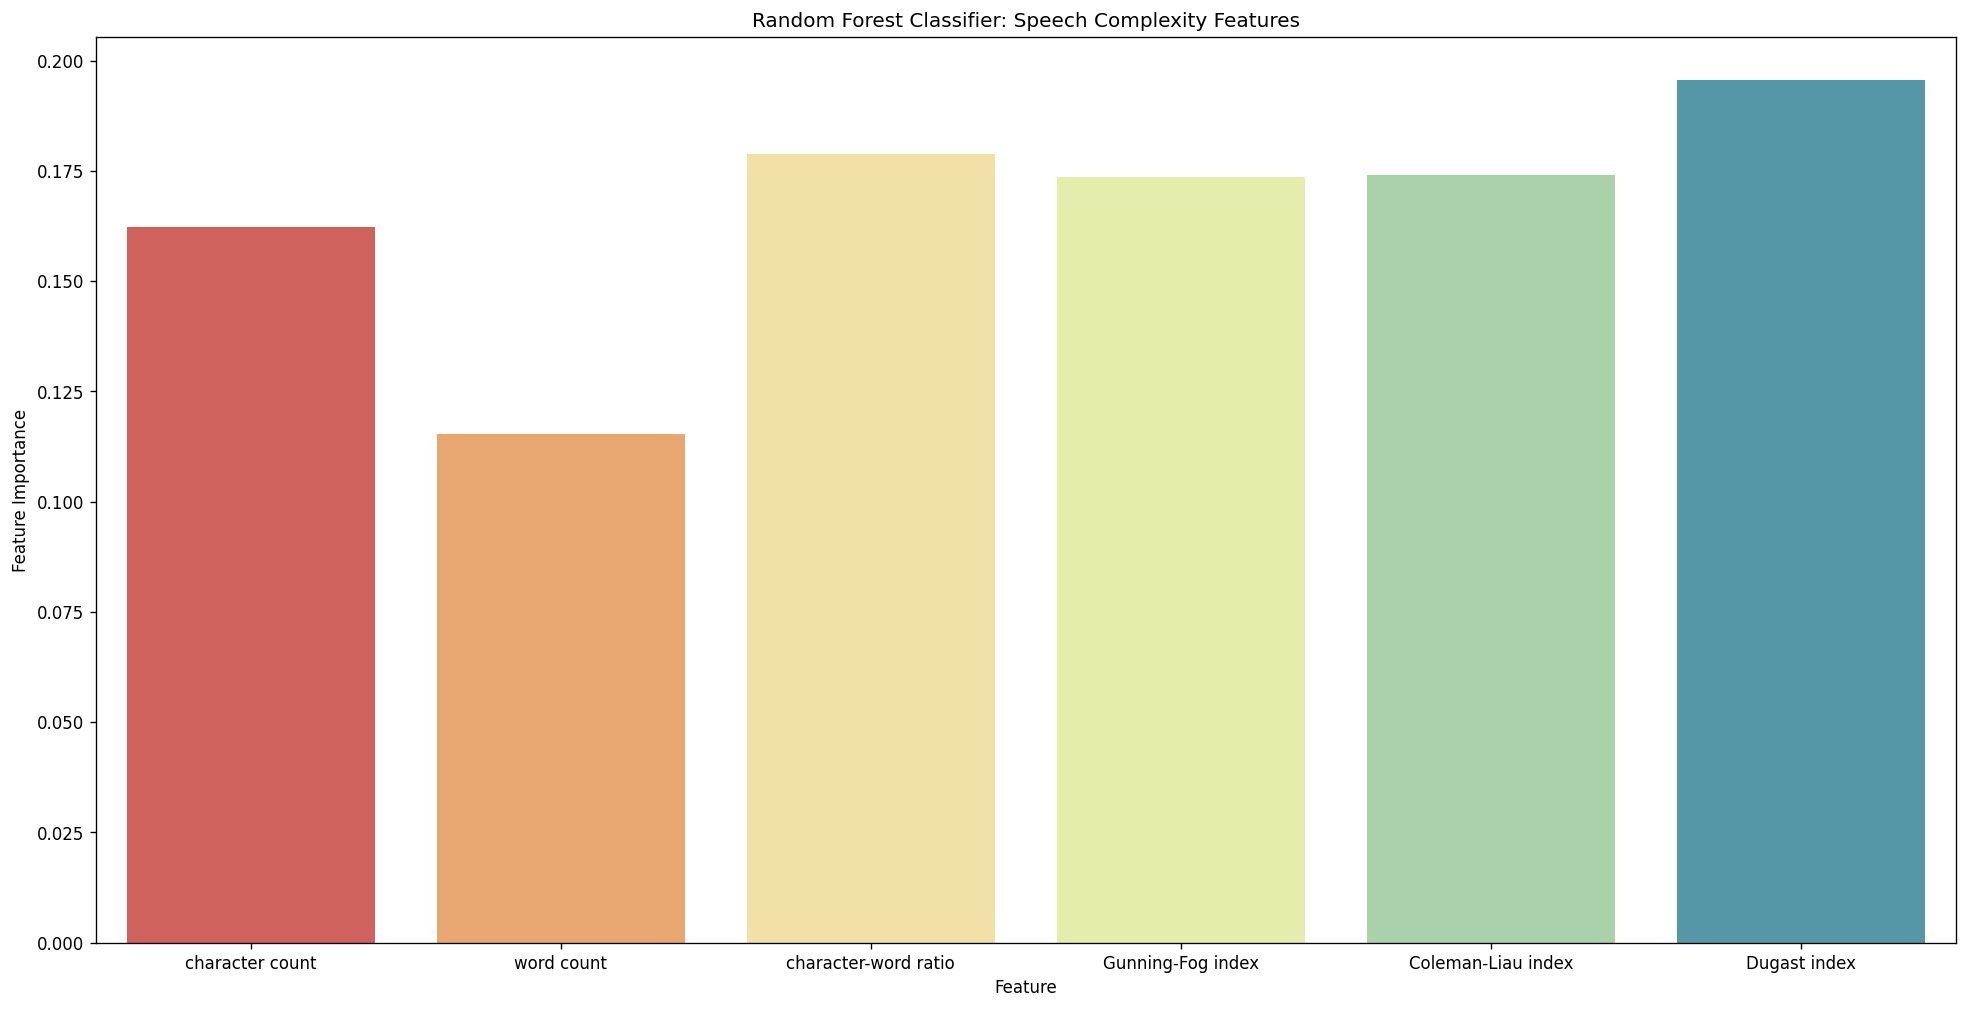

In [45]:
fig, ax = plt.subplots(1,1, figsize = (20,10), dpi = 120)

remapped_order =  ['char_count', 'word_count', 'cwc_ratio', 'gunning_fog', 'coleman_liau', 'dugast']
remapped_labels = ["character count","word count", "character-word ratio","Gunning-Fog index","Coleman-Liau index","Dugast index"]


sns.barplot(x=train_data.columns, y = rf_2.feature_importances_, palette = "Spectral", order = remapped_order, ax = ax)
ax.set_ylabel("Feature Importance")
ax.set_xlabel("Feature")
ax.axes.set_xticklabels(remapped_labels)

plt.title("Random Forest Classifier: Speech Complexity Features")
plt.savefig(PLOT_PATH + 'random_forest_some.png')
plt.show()